In [35]:
import random
import collections
import seaborn as sns
import os
import glob
import numpy as np
from sklearn.decomposition import PCA
import re
import pandas as pd
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
plt.style.use('ggplot')

random.seed(42)
np.random.seed(42)

Автоматический поиск произведений в папках texts/txt/\*\* (вместо \*\* — имя автора) и создание словарей *название-путь\_к\_файлу* (TITLE_PATH_DICT), *название-автор* (TITLE_AUTHOR_DICT), *автор-множество\_названий\_произведений* (AUTHOR__TITLE_SET__DICT).

In [2]:
FILE_PATHS = glob.glob('texts/converted/**/*.txt', recursive=True)

In [3]:
TITLE_PATH_DICT = {path.split("\\")[-1].split(".")[0] : path for path in FILE_PATHS}
TITLE_AUTHOR_DICT = {path.split("\\")[-1].split(".")[0] : path.split("\\")[-2] for path in FILE_PATHS}

In [4]:
AUTHOR__TITLE_SET__DICT = collections.defaultdict(set)
for title, author in TITLE_AUTHOR_DICT.items():
    AUTHOR__TITLE_SET__DICT[author].add(title)
AUTHOR__TITLE_SET__DICT = dict(AUTHOR__TITLE_SET__DICT)

In [5]:
NPY_FOLDER = 'texts/500_sentences/'

## _

In [62]:
# patterns = "[A-Za-z0-9!#$%&'()*+,.…«»/:;<=>?@[\]^_`{|}~—\"\-]+"
patterns = r'[^а-яё ]+'
morph = MorphAnalyzer()

def lemmatize(doc, remove_stop_words=True):
    doc = re.sub(patterns, ' ', doc.lower()).strip().replace('ё', 'е')
    tokens = []
    stopwords_ru = stopwords.words("russian") if remove_stop_words else ''
    for token in doc.split():
        if token and token.strip() not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    return tokens

In [63]:
excerpt_mul = 1
num_of_npys = len(glob.glob(f'{NPY_FOLDER}/**/*.npy', recursive=True))
rows = []
with tqdm(total=num_of_npys) as pbar:
    for author in AUTHOR__TITLE_SET__DICT.keys():
            npy_paths = glob.glob(f'{NPY_FOLDER}/{author}/*.npy', recursive=True)
            for i in range(0, len(npy_paths), excerpt_mul):
                text = ''
                for npy_path in npy_paths[i:i+excerpt_mul]:
                    text += ' '.join(np.load(npy_path)).replace('ё', 'е')
                rows.append(
                    {
                        'author': author, 
                        'text': text,
                        'lemmas': ' '.join(lemmatize(text))
                    })
                pbar.update(min(excerpt_mul, len(npy_paths)-i))
df = pd.DataFrame(rows)

100%|████████████████████████████████████████████████████████████████████████████████| 854/854 [05:20<00:00,  2.67it/s]


In [64]:
df.to_csv('500_sentences.csv', index=False)

In [6]:
df = pd.read_csv('500_sentences.csv')

In [7]:
df

,author,text,lemmas
0,anton-chekhov,"\n Белолобый \n Голодная волчиха встала, чтобы...",белолобый голодный волчиха встать идти охота в...
1,anton-chekhov,"не буду! Мамаша, не буду! Руку! \n — Тем б...",быть мамаша быть рука подавать повод продолжат...
2,anton-chekhov,\n Сторож уже давно не стучит. Под окном и в...,сторож давно стучать окно сад зашуметь птица т...
3,anton-chekhov,"\n — Я с вами, папаша, вполне согласен, — гов...",вы папаша вполне согласный говорить хриплый те...
4,anton-chekhov,Свойкин опустился на диван и принялся ждать. ...,свойкин опуститься диван приняться ждать касси...
...,...,...,...
849,sergey-aksakov,\n В городе беспрестанно получались разные из...,город беспрестанно получаться разный известие ...
850,sergey-aksakov,Я осмелился подойти поближе и стал возле Чича...,осмелиться подойти близкий стать возле чичагов...
851,sergey-aksakov,Много содействовали тому разговоры с отцом и ...,содействовать тот разговор отец евсеевич котор...
852,sergey-aksakov,Мать очень любила и дорожила полевой клубнико...,мать очень любить дорожить полевой клубника сч...


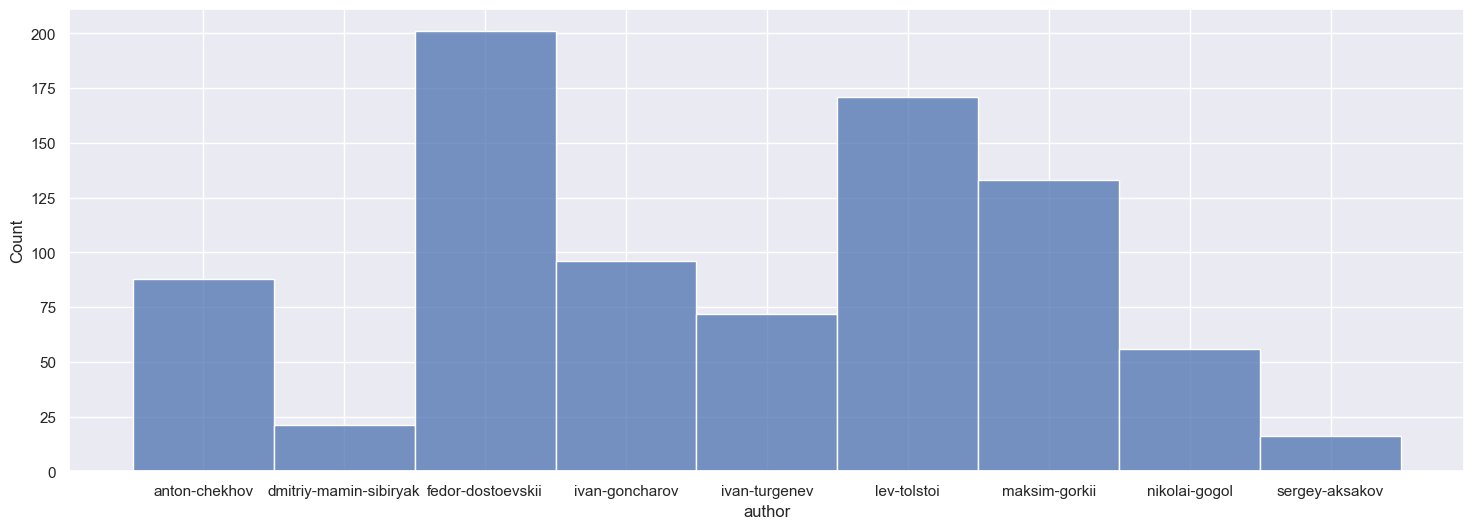

In [8]:
sns.set(rc={'figure.figsize':(18,6)})
sns.histplot(data=df, x=df['author'],)
plt.show();

In [9]:
df_train, df_test = train_test_split(df, test_size=0.2)

In [58]:
%%time
char_vec_l = TfidfVectorizer(analyzer='char', ngram_range=(1, 6), sublinear_tf=True) 
clX_train = char_vec_l.fit_transform(df_train['lemmas'])

CPU times: total: 58.3 s
Wall time: 58.3 s


In [59]:
%%time
char_vec_t = TfidfVectorizer(analyzer='char', ngram_range=(1, 2), sublinear_tf=True) 
ctX_train = char_vec_t.fit_transform(df_train['text'])

CPU times: total: 14.1 s
Wall time: 14.2 s


In [60]:
%%time
char_pca = TruncatedSVD(100)
cX_train = hstack([clX_train, ctX_train])
char_pca.fit(cX_train)
cX_train_pca = char_pca.transform(cX_train)

CPU times: total: 2min 2s
Wall time: 1min 29s


In [61]:
y_train = df_train['author']
X_train = np.copy(cX_train_pca)

normalizer = StandardScaler()
normalizer.fit(X_train)
X_train_scaled = normalizer.transform(X_train)

In [62]:
clf = LogisticRegression(random_state=42, max_iter=50000, warm_start=True, C=1)
ran = np.arange(y_train.shape[0])
inds = np.array_split(ran, 10)
inds = [np.concatenate((chunk, np.array(random.sample(list(ran), k=50))), axis=None) for chunk in inds]

for chunk in tqdm(inds):
    clf.fit(X_train_scaled[chunk, :], y_train.iloc[chunk].values.ravel())

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 53.19it/s]


In [63]:
def get_features(df_test):
    if 'author' in df_test.columns:
        y_test = df_test.author
    else:
        y_test = None
    
    clX_test = char_vec_l.transform(df_test['lemmas'])
    ctX_test = char_vec_t.transform(df_test['text'])
    
    cX_test = hstack([clX_test, ctX_test])
    cX_test_pca = char_pca.transform(cX_test)
    
    X_test = cX_test_pca
    X_test_scaled = normalizer.transform(X_test)
    return X_test_scaled, y_test

In [64]:
%%time
X_test_scaled, y_test = get_features(df_test)

CPU times: total: 19.5 s
Wall time: 18.7 s


In [65]:
pred_test = clf.predict(X_test_scaled)
f1_score(y_test, pred_test, average='micro')

0.9005847953216374

In [66]:
def baseline(df_train, df_test):
    pred = df_train.groupby(by='author').count()['text'].idxmax()
    return [pred for i in range(df_test.shape[0])]

In [68]:
pred_test_baseline = baseline(df_train, df_test)
f1_score(y_test, pred_test_baseline, average='micro')

0.23391812865497075